In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/mrl.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import  image
from tensorflow.keras.layers import Dropout,Input,Flatten,Dense,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data Augumentation

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
batchsize=8

In [6]:
train_datagen= ImageDataGenerator(rescale=1./255, rotation_range=0.2,shear_range=0.2,
    zoom_range=0.2,width_shift_range=0.2,
    height_shift_range=0.2, validation_split=0.2)

train_data= train_datagen.flow_from_directory(r'/tmp/mrl/train',
                                target_size=(80,80),batch_size=batchsize,class_mode='categorical',subset='training' )

validation_data= train_datagen.flow_from_directory(r'/tmp/mrl/train',
                                target_size=(80,80),batch_size=batchsize,class_mode='categorical', subset='validation')

Found 50940 images belonging to 2 classes.
Found 12733 images belonging to 2 classes.


In [7]:
train_data.class_indices

{'closed_eye': 0, 'open_eye': 1}

In [8]:
train_data.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(r'/tmp/mrl/test',
                                target_size=(80,80),batch_size=batchsize,class_mode='categorical')

Found 21225 images belonging to 2 classes.


In [10]:
bmodel = InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(80,80,3)))
hmodel = bmodel.output
hmodel = Flatten()(hmodel)
hmodel = Dense(64, activation='relu')(hmodel)
hmodel = Dropout(0.5)(hmodel)
hmodel = Dense(2,activation= 'softmax')(hmodel)

model = Model(inputs=bmodel.input, outputs= hmodel)
for layer in bmodel.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 39, 39, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 39, 39, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 39, 39, 32)           0         ['batch_normalization[0][0

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

In [13]:
checkpoint = ModelCheckpoint(r'/tmp/mrl/inceptionv3.h5',
                            monitor='val_loss',save_best_only=True,verbose=3)

earlystop = EarlyStopping(monitor = 'val_loss', patience=7, verbose= 3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3, )

callbacks=[checkpoint,earlystop,learning_rate]

In [14]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

model_fit = model.fit_generator(train_data,steps_per_epoch=train_data.samples//batchsize,
                   validation_data=validation_data,
                   validation_steps=validation_data.samples//batchsize,
                   callbacks=callbacks,
                    epochs=10
                    )

<ipython-input-14-bb473a7ecc79>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_fit = model.fit_generator(train_data,steps_per_epoch=train_data.samples//batchsize,


Epoch 1/10
6367/6367 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9181
Epoch 1: val_loss improved from inf to 0.22220, saving model to /tmp/mrl/inceptionv3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6367/6367 [==============================] - 304s 45ms/step - loss: 0.2076 - accuracy: 0.9181 - val_loss: 0.2222 - val_accuracy: 0.9138 - lr: 0.0010
Epoch 2/10
6367/6367 [==============================] - ETA: 0s - loss: 0.1794 - accuracy: 0.9294
Epoch 2: val_loss did not improve from 0.22220
6367/6367 [==============================] - 242s 38ms/step - loss: 0.1794 - accuracy: 0.9294 - val_loss: 0.2519 - val_accuracy: 0.9026 - lr: 0.0010
Epoch 3/10
6367/6367 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9336
Epoch 3: val_loss did not improve from 0.22220
6367/6367 [==============================] - 282s 44ms/step - loss: 0.1720 - accuracy: 0.9336 - val_loss: 0.2230 - val_accuracy: 0.9126 - lr: 0.0010
Epoch 4/10
6366/6367 [============================>.] - ETA: 0s - loss: 0.1690 - accuracy: 0.9352
Epoch 4: val_loss did not improve from 0.22220

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
6367/6367 [=============================

In [15]:
# Model Evaluation

In [16]:
loss_tr, acc_tr = model.evaluate_generator(train_data)
print(acc_tr)
print(loss_tr)

<ipython-input-16-86587479d2ec>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_tr, acc_tr = model.evaluate_generator(train_data)


0.9334707260131836
0.1680450141429901


In [17]:
loss_vr, acc_vr  = model.evaluate_generator(validation_data)
print(acc_vr)
print(loss_vr)

<ipython-input-17-d0b063599fc3>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_vr, acc_vr  = model.evaluate_generator(validation_data)


0.9162805080413818
0.21842160820960999


In [18]:
loss_test, acc_test = model.evaluate_generator(test_data)
print(acc_test)
print(loss_test)

<ipython-input-18-546d969a243a>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss_test, acc_test = model.evaluate_generator(test_data)


0.9389399290084839
0.1554834097623825


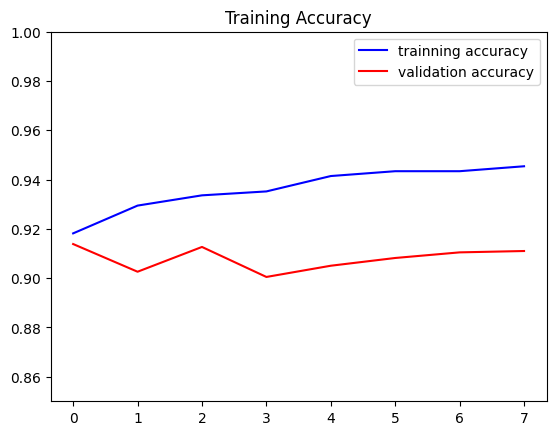

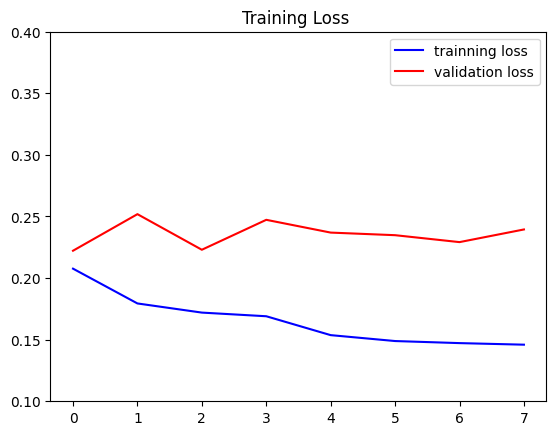

<Figure size 640x480 with 0 Axes>

In [25]:
accuracy = model_fit.history['accuracy']
val_accuracy = model_fit.history['val_accuracy']
loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs = range(len(accuracy))



plt.title("Training Accuracy")
plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.ylim(0.85, 1)
plt.show()
plt.savefig("Accuracy.jpg")


plt.title("Training Loss ")
plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.ylim(0.1, 0.4)
plt.show()
plt.savefig("Loss.jpg")